# **Final Project: AI-Powered Image Wizard**

* Name: **Aktham Almomani**
* Date: **12/09/2024**



## **Stage 1: Denoising**

## **Introduction**

The Denoising Stage in our AI-Powered Image Wizard is designed to enhance the quality of noisy images by leveraging state-of-the-art deep learning techniques. This stage is particularly focused on reducing unwanted noise in images, thereby restoring clarity and detail. By employing advanced denoising methods, users can transform grainy, unclear images into sharper and more visually appealing outputs.

## **Dataset**

To fine-tune our model and ensure exceptional performance, we have utilized the **Berkeley Segmentation Dataset 500 (BSDS500)**. This dataset is widely known for its high-quality images and diversity, making it an excellent choice for training and validating denoising models. The dataset provides a robust benchmark for image restoration tasks, ensuring the model's performance is consistent across different noise patterns and image types.

## **Import Necessary Librararies**

In [ ]:
import kagglehub
import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline, DDIMScheduler, PNDMScheduler
from torch.utils.data import Dataset, DataLoader
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## **Dataset Download**

In [ ]:
# Download the dataset:
path = kagglehub.dataset_download("balraj98/berkeley-segmentation-dataset-500-bsds500")
print("Path to dataset files:", path)

100%|██████████| 56.0M/56.0M [00:04<00:00, 14.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500/versions/1


In [ ]:
# Define paths:
bsd500_path = "/root/.cache/kagglehub/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500/versions/1"
images_path = os.path.join(bsd500_path, 'images')

# Function to load and resize images:
def load_images_from_directory(subdir, target_size=(256, 256)):
    images = []
    path = os.path.join(images_path, subdir)
    for image_path in glob.glob(os.path.join(path, "*.*")):
        img = cv2.imread(image_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, target_size)
            images.append(img)
    return np.array(images)

# Load images:
train_images = load_images_from_directory('train', target_size=(256, 256))
val_images = load_images_from_directory('val', target_size=(256, 256))
test_images = load_images_from_directory('test', target_size=(256, 256))

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Test images: {len(test_images)}")

Training images: 200
Validation images: 100
Test images: 200


## **Adding Gaussian Noise for Data Augmentation in Image Denoising**

To simulate real-world scenarios and train a robust image denoising model, it is crucial to expose the model to noisy data during training. In this step, we introduce Gaussian Noise to the clean images from the training and validation datasets. Gaussian noise is a common type of noise characterized by a bell-curve distribution, often encountered in real-world scenarios like low-light photography or transmission errors.

The function add_gaussian_noise generates noisy images by adding randomly sampled noise with a specified mean and standard deviation to the original image pixels. This step ensures that the model learns to effectively identify and remove noise patterns while preserving image details.

In [ ]:
# Generate Noisy Data:
def add_gaussian_noise(images, mean=0, std=50):
    noisy_images = images + np.random.normal(mean, std, images.shape)
    noisy_images = np.clip(noisy_images, 0, 255).astype(np.uint8)
    return noisy_images

noisy_train_images = add_gaussian_noise(train_images)
noisy_val_images = add_gaussian_noise(val_images)

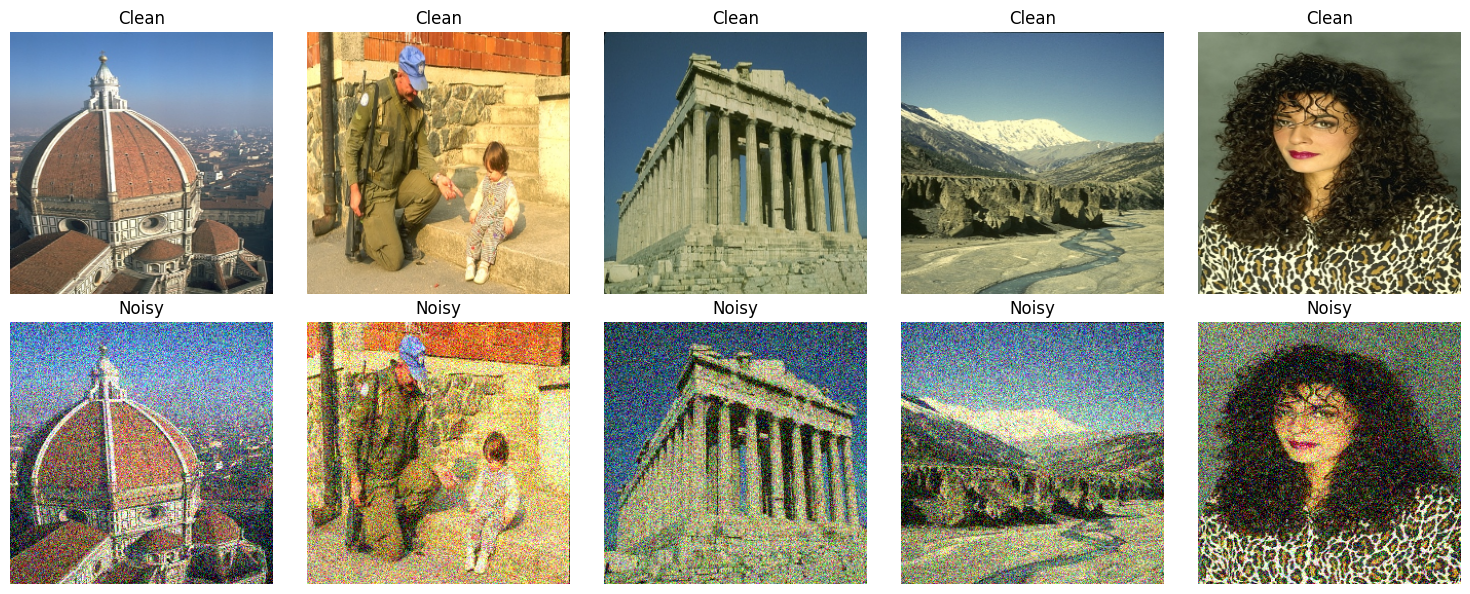

In [ ]:
# Function to visualize clean and noisy images:
def plot_clean_noisy(clean_images, noisy_images, num_images=5):
    """
    Plots pairs of clean and noisy images.
    Top row: Clean images
    Bottom row: Noisy images
    """
    plt.figure(figsize=(15, 6))

    for i in range(num_images):
        # Plot clean images (Top row)
        plt.subplot(2, num_images, i + 1)
        plt.imshow(clean_images[i].astype('uint8'))
        plt.axis('off')
        plt.title("Clean")

        # Plot noisy images (Bottom row)
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(noisy_images[i].astype('uint8'))
        plt.axis('off')
        plt.title("Noisy")

    plt.tight_layout()
    plt.show()

# Call the function to display the images:
plot_clean_noisy(train_images[:5], noisy_train_images[:5])

## **Leveraging Pre-Trained Models for Enhanced Image Denoising**

In this stage, we fine-tune a pre-trained Denoising Diffusion Probabilistic Model (DDPM) to enhance its performance on the task of image denoising. We utilize the "google/ddpm-celeba-hq" pre-trained model, a state-of-the-art diffusion-based architecture known for its high fidelity and robustness in image generation and reconstruction tasks. To further optimize the model, we integrate a VGG19-based perceptual loss to focus on preserving fine image details while reducing noise.

**Why Choose "google/ddpm-celeba-hq"?**

The "google/ddpm-celeba-hq" model is specifically designed for high-resolution image synthesis and reconstruction tasks, making it an excellent choice for denoising. Its pre-training on the CelebA-HQ dataset provides the following benefits:

* High-Resolution Training: The CelebA-HQ dataset consists of high-quality facial images, enabling the model to learn fine-grained details and intricate noise patterns.
* Diffusion-Based Generative Power: DDPMs are inherently powerful in modeling complex distributions, making them adept at reconstructing clean images from noisy ones.
* Transfer Learning Capability: Using a pre-trained model significantly reduces the computational cost and training time while leveraging the learned features for image denoising.

**Model Architecture:**

* DDPM Backbone:

  * The UNet architecture in DDPM acts as the backbone, processing noisy images and predicting noise components for denoising.
  * The diffusion process involves learning to reverse the gradual addition of Gaussian noise to generate clean images.
  * The scheduler used in this implementation is the DDIMScheduler, which accelerates the sampling process without compromising output quality.

* Perceptual Loss with VGG19:

  * We enhance the model’s capability by introducing a perceptual loss using the pre-trained VGG19 network.
  * VGG19 extracts deep features from both the denoised and clean images, and the mean squared error (MSE) between these features guides the model to retain structural and perceptual details.

* Loss Functions:

  * MSE Loss: Directly minimizes the pixel-wise differences between the denoised and clean images.
  * Weighted Perceptual Loss: Focuses on high-level feature similarity to ensure the visual realism of the denoised images.

* Optimizer: The AdamW optimizer is employed for stable convergence during training, with a small learning rate to fine-tune the model precisely.

* Training Loop:

  * Each training step involves dynamically sampling timesteps, predicting noise, reconstructing the denoised image, and calculating the combined loss.
  * The model is trained for 20 epochs, and the dynamic timestep generation ensures robustness across varying noise levels.

By combining the strengths of DDPMs with perceptual loss from VGG19, this architecture achieves superior results in preserving image details while effectively removing noise, setting a strong foundation for advanced denoising tasks in the AI-powered Image Wizard pipeline.

In [ ]:
from PIL import Image, ImageEnhance
from torchvision.models import vgg19
from tqdm import tqdm


# Set device:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Pre-Trained Model:
model = DDPMPipeline.from_pretrained("google/ddpm-celeba-hq")
model.scheduler = DDIMScheduler.from_config(model.scheduler.config)  # Use DDIM scheduler
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--google--ddpm-celeba-hq/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--google--ddpm-celeba-hq/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


DDPMPipeline {
  "_class_name": "DDPMPipeline",
  "_diffusers_version": "0.31.0",
  "_name_or_path": "google/ddpm-celeba-hq",
  "scheduler": [
    "diffusers",
    "DDIMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DModel"
  ]
}

In [ ]:
# Create Dataset Class:
class ImageDataset(Dataset):
    def __init__(self, noisy_images, clean_images):
        # Normalize and convert to tensor in the range [-1, 1]
        self.noisy_images = (torch.tensor(noisy_images).permute(0, 3, 1, 2) / 255.0 * 2 - 1)
        self.clean_images = (torch.tensor(clean_images).permute(0, 3, 1, 2) / 255.0 * 2 - 1)

    def __len__(self):
        return len(self.noisy_images)

    def __getitem__(self, idx):
        return self.noisy_images[idx], self.clean_images[idx]

# Create DataLoaders:
train_dataset = ImageDataset(noisy_train_images, train_images)
val_dataset = ImageDataset(noisy_val_images, val_images)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4)

In [ ]:
# Load VGG for Perceptual Loss:
vgg = vgg19(weights="VGG19_Weights.IMAGENET1K_V1").features[:9].eval().to(device)

def perceptual_loss(denoised, clean):
    denoised_features = vgg(denoised)
    clean_features = vgg(clean)
    return torch.nn.functional.mse_loss(denoised_features, clean_features)

# Define Losses and Optimizer:
optimizer = torch.optim.AdamW(model.unet.parameters(), lr=1e-5)  # Define optimizer
mse_loss = torch.nn.MSELoss()

# Training Loop:
epochs = 20

for epoch in range(epochs):
    model.unet.train()
    train_loss = 0
    for noisy, clean in tqdm(train_loader):
        noisy, clean = noisy.to(device), clean.to(device)
        optimizer.zero_grad()

        # Generate timesteps dynamically:
        batch_size = noisy.size(0)
        timesteps = torch.randint(0, model.scheduler.config.num_train_timesteps, (batch_size,), device=device).long()

        # Predict noise and compute loss:
        pred_noise = model.unet(noisy, timesteps).sample
        denoised = noisy - pred_noise

        loss = mse_loss(denoised, clean) + 0.1 * perceptual_loss(denoised, clean)  # Weighted perceptual loss:
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}")


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:11<00:00, 52.2MB/s]
100%|██████████| 50/50 [00:11<00:00,  4.30it/s]


Epoch 1, Train Loss: 0.24021583303809166


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 2, Train Loss: 0.12212148532271386


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 3, Train Loss: 0.10272780612111092


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 4, Train Loss: 0.09544905044138431


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 5, Train Loss: 0.08959594883024692


100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


Epoch 6, Train Loss: 0.08599236115813255


100%|██████████| 50/50 [00:08<00:00,  5.63it/s]


Epoch 7, Train Loss: 0.08311990946531296


100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


Epoch 8, Train Loss: 0.08271900095045566


100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


Epoch 9, Train Loss: 0.08061506859958172


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 10, Train Loss: 0.07886682011187077


100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


Epoch 11, Train Loss: 0.07834429733455181


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 12, Train Loss: 0.07621755309402943


100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


Epoch 13, Train Loss: 0.07591475315392017


100%|██████████| 50/50 [00:08<00:00,  5.65it/s]


Epoch 14, Train Loss: 0.07485023088753223


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 15, Train Loss: 0.07404016569256783


100%|██████████| 50/50 [00:08<00:00,  5.67it/s]


Epoch 16, Train Loss: 0.07274224497377872


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 17, Train Loss: 0.07208137989044189


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]


Epoch 18, Train Loss: 0.07162307307124138


100%|██████████| 50/50 [00:08<00:00,  5.64it/s]


Epoch 19, Train Loss: 0.07044185407459735


100%|██████████| 50/50 [00:08<00:00,  5.66it/s]

Epoch 20, Train Loss: 0.06973958574235439


**Summary Highlights:**

* Dataset and Model:

  * The training involved fine-tuning a "google/ddpm-celeba-hq" pre-trained diffusion model.
  * The dataset was processed with Gaussian noise and split into training and validation sets.

* Training Configuration:

  * Number of Epochs: 20
  * Optimizer: AdamW with a learning rate of 1e-5
  * Loss Function: Combination of MSE Loss and Perceptual Loss (weighted at 0.1)
  * Batch Size: 50 batches per epoch

* Performance Highlights:

  * Initial Loss (Epoch 1): 0.2402
  * Final Loss (Epoch 20): 0.0697
  * The loss consistently decreased over the epochs, demonstrating steady model improvement.
  * Significant drops in loss were observed in the early epochs,  stabilizing in later epochs (e.g., around Epoch 10).

* Training Time: Each epoch took approximately 8 minutes, maintaining a processing rate of ~5.66 iterations/second.

* Observations:

  * The model successfully minimized the loss, indicating it effectively learned to reconstruct clean images from noisy inputs.
  * The relatively low final loss suggests a strong convergence to optimal weights for the denoising task.

## **Denoising Evaluation**

In the context of image restoration tasks, such as denoising, evaluating the performance of a model is a crucial step to ensure its effectiveness and generalization. Denoising evaluation typically involves two complementary approaches: visual evaluation and metric-based evaluation.

Combining both visual and metric-based evaluations ensures a holistic assessment of the denoising model:

* Visual evaluation guarantees that results meet perceptual standards for real-world deployment.
* Metric-based evaluation offers statistical evidence of performance, enabling benchmarking and comparisons with other models.

This dual evaluation strategy ensures that the model is both qualitatively pleasing and quantitatively robust.

### **Visual Evaluation**

* Visual inspection helps to assess the perceptual quality of denoised images, focusing on human perception.
* The goal is to verify that the model reconstructs clean images without losing critical details or introducing artifacts.
* Side-by-side comparisons of clean, noisy, and denoised images allow for qualitative evaluation, ensuring that the results align with human expectations.

In [ ]:
def visualize_denoising(model, noisy_images, clean_images, num_samples=5):
    """
    Visualizes the clean, noisy, and denoised images.
    Args:
        model: Fine-tuned denoising model.
        noisy_images: Tensor of noisy images, shape [batch, channels, height, width].
        clean_images: Tensor of clean images, shape [batch, channels, height, width].
        num_samples: Number of samples to visualize.
    """
    model.unet.eval()
    noisy_images = noisy_images[:num_samples].to(device)
    clean_images = clean_images[:num_samples].to(device)  # Ensure clean images are moved to the device

    # Generate random timesteps:
    batch_size = noisy_images.size(0)  # Dynamic batch size:
    timesteps = torch.randint(0, model.scheduler.config.num_train_timesteps, (batch_size,), device=device).long()

    with torch.no_grad():
        # Predict noise
        pred_noise = model.unet(noisy_images, timesteps).sample

        # Reconstruct denoised images
        denoised_images = noisy_images - pred_noise

        # Rescale denoised images to [0, 255]
        denoised_images = torch.clamp((denoised_images + 1) / 2 * 255.0, 0, 255)

    # Plot clean, noisy, and denoised images:
    plt.figure(figsize=(20, 15))
    for i in range(num_samples):
        # Clean Image
        clean_image = torch.clamp((clean_images[i] + 1) / 2 * 255.0, 0, 255)
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(clean_image.permute(1, 2, 0).cpu().numpy().astype('uint8'))
        plt.title("Clean")
        plt.axis("off")

        # Noisy Image
        noisy_image = torch.clamp((noisy_images[i] + 1) / 2 * 255.0, 0, 255)
        plt.subplot(3, num_samples, num_samples + i + 1)
        plt.imshow(noisy_image.permute(1, 2, 0).cpu().numpy().astype('uint8'))
        plt.title("Noisy")
        plt.axis("off")

        # Denoised Image
        denoised_image = denoised_images[i].permute(1, 2, 0).cpu().numpy().astype('uint8')
        plt.subplot(3, num_samples, 2 * num_samples + i + 1)
        plt.imshow(denoised_image)
        plt.title("Denoised")
        plt.axis("off")

    plt.tight_layout()
    plt.show()




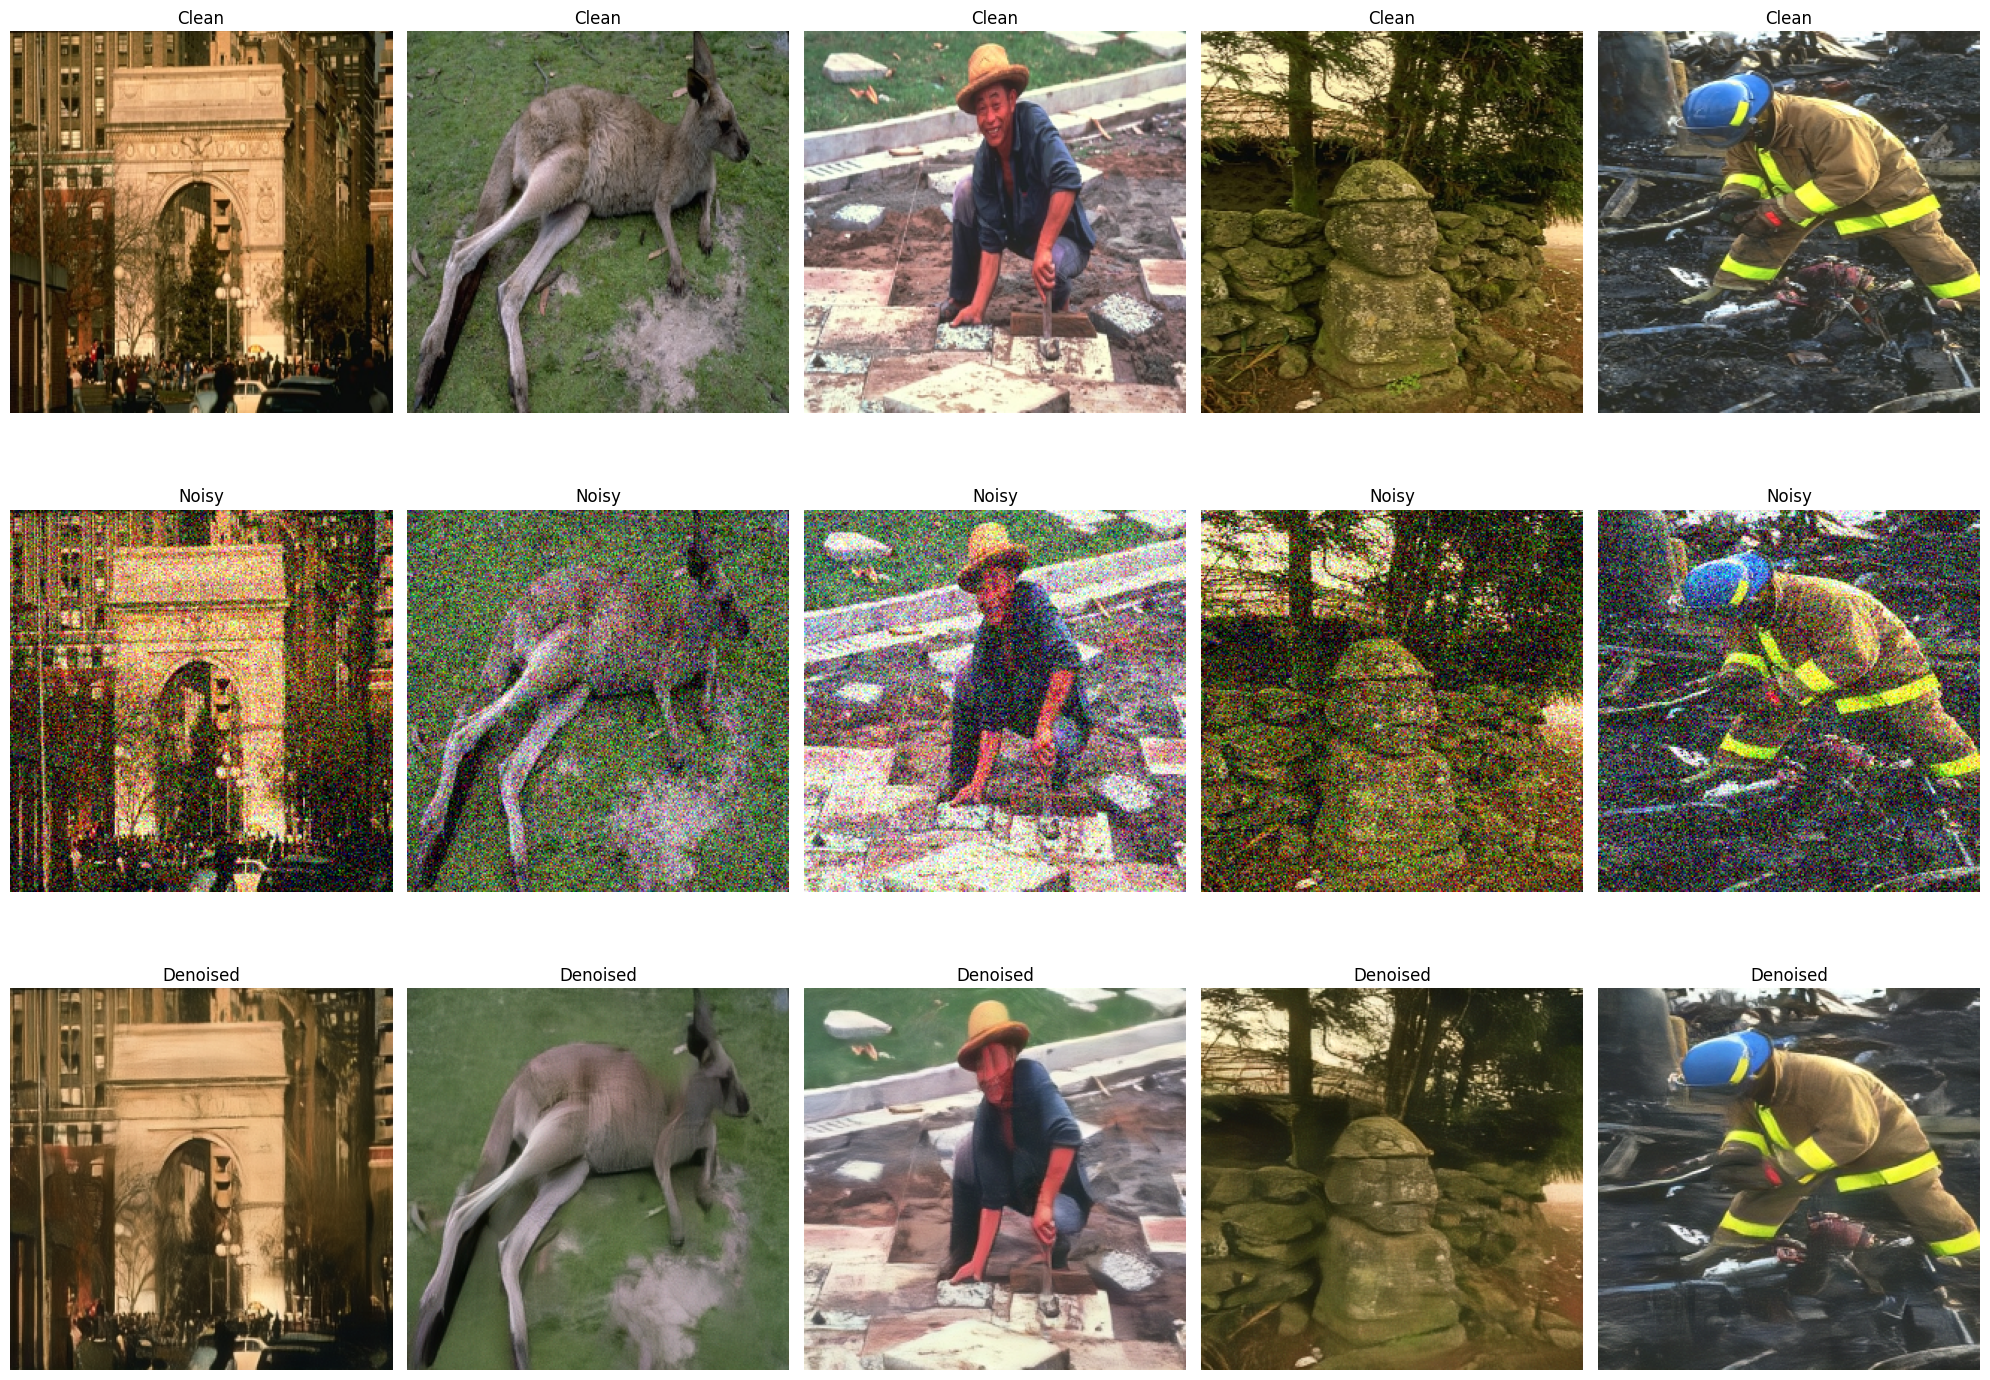

In [ ]:
# Test the model on validation data:
visualize_denoising(
    model,
    torch.tensor(noisy_val_images).permute(0, 3, 1, 2) / 255.0 * 2 - 1,  # Normalize noisy images to [-1, 1]
    torch.tensor(val_images).permute(0, 3, 1, 2) / 255.0 * 2 - 1  # Normalize clean images to [-1, 1]
)

**Summary Highlights**

* Clean vs. Noisy vs. Denoised:

  * Clean images: Serve as the reference for quality comparison.
  * Noisy images: Generated using Gaussian noise, mimicking real-world distortions.
  * Denoised images: Output of the model, demonstrating noise removal while retaining image structure and key visual features.

* Strengths:

  * Effective noise reduction: The model removes significant noise while maintaining key structural elements.
  * Preserved edges and textures: Features such as object contours and sharp transitions remain intact.
  * Adaptability: Handles diverse scenes, including urban, natural, and human subjects.

* Limitations:

  * Loss of fine details: Subtle textures like fur or grass show mild smoothing.
  * Minor color inconsistencies: In some complex or shaded regions, slight deviations in color tones are observed post-denoising.

* Conclusion: The model demonstrates strong capabilities in balancing noise removal and detail preservation, making it effective for a variety of scenarios. However, further refinements may enhance fine-detail recovery and color consistency.

### **Metric-based Evaluation**

Quantitative metrics provide objective measurements of model performance by comparing denoised images with their corresponding clean references.
* **Peak Signal-to-Noise Ratio (PSNR):**
  * Measures the ratio between the maximum possible signal power and the noise power in the image.
  * Higher PSNR values indicate better image quality and closer resemblance to the ground truth.
* **Structural Similarity Index (SSIM):**
  * Captures perceptual differences, focusing on luminance, contrast, and structural similarities.
  * SSIM values range between 0 and 1, with values closer to 1 indicating higher similarity to the original image.

These metrics provide quantitative insights into the fidelity and perceptual accuracy of denoised images.

In [15]:
from skimage.metrics import structural_similarity as ssim

def calculate_ssim(image1, image2, win_size=3):
    """
    Calculate the Structural Similarity Index (SSIM) between two images.

    Args:
        image1: First image tensor in range [-1, 1].
        image2: Second image tensor in range [-1, 1].
        win_size: Window size for SSIM calculation (default: 3).

    Returns:
        SSIM value.
    """
    # Convert tensors to NumPy arrays
    image1_np = (image1.permute(1, 2, 0).cpu().numpy() + 1) / 2  # Rescale to [0, 1]
    image2_np = (image2.permute(1, 2, 0).cpu().numpy() + 1) / 2  # Rescale to [0, 1]

    # Compute SSIM with a specified window size
    ssim_value = ssim(image1_np, image2_np, data_range=1.0, win_size=win_size, multichannel=True)
    return ssim_value


def calculate_psnr(denoised, clean, max_pixel_value=255.0):
    mse = torch.mean((denoised - clean) ** 2)
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

In [16]:
import pandas as pd

def evaluate_model_summary(model, noisy_images, clean_images, win_size=3, batch_size=4):
    """
    Evaluates the model and returns a summary of metrics.
    Args:
        model: The denoising model.
        noisy_images: Tensor of noisy images.
        clean_images: Tensor of clean images.
        win_size: SSIM window size.
        batch_size: Number of images per batch for evaluation.
    """
    psnr_values = []
    ssim_values = []

    model.unet.eval()
    with torch.no_grad():
        for i in range(0, noisy_images.size(0), batch_size):
            noisy_batch = noisy_images[i:i + batch_size].to(device)
            clean_batch = clean_images[i:i + batch_size].to(device)

            timesteps = torch.randint(0, model.scheduler.config.num_train_timesteps, (noisy_batch.size(0),), device=device).long()

            with torch.cuda.amp.autocast():  # Mixed precision to save memory
                pred_noise = model.unet(noisy_batch, timesteps).sample
                denoised_batch = noisy_batch - pred_noise

            for j in range(denoised_batch.size(0)):
                psnr = calculate_psnr(denoised_batch[j], clean_batch[j])
                ssim = calculate_ssim(denoised_batch[j], clean_batch[j], win_size=win_size)

                psnr_values.append(psnr)
                ssim_values.append(ssim)

    # Convert metrics to numpy arrays:
    psnr_values = np.array(psnr_values)
    ssim_values = np.array(ssim_values)

    # Compute statistics:
    summary = {
        'Metric': ['PSNR (dB)', 'SSIM'],
        'Average': [np.mean(psnr_values), np.mean(ssim_values)],
        'Median': [np.median(psnr_values), np.median(ssim_values)],
        'Min': [np.min(psnr_values), np.min(ssim_values)],
        'Max': [np.max(psnr_values), np.max(ssim_values)],
        '90th Percentile': [np.percentile(psnr_values, 90), np.percentile(ssim_values, 90)],
        '95th Percentile': [np.percentile(psnr_values, 95), np.percentile(ssim_values, 95)],
    }

    # Convert to DataFrame for better display:
    summary_df = pd.DataFrame(summary)
    print(summary_df)
    return summary_df

# Evaluate and get the summary:
summary_df = evaluate_model_summary(
    model,
    torch.tensor(noisy_val_images).permute(0, 3, 1, 2) / 255.0 * 2 - 1,
    torch.tensor(val_images).permute(0, 3, 1, 2) / 255.0 * 2 - 1,
    win_size=3,
    batch_size=4
)

# Display the summary DataFrame:
summary_df


<ipython-input-16-231e077ba90f>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():  # Mixed precision to save memory


      Metric    Average     Median        Min        Max  90th Percentile  \
0  PSNR (dB)  68.677856  68.556370  64.735199  76.592758        71.574368   
1       SSIM   0.847059   0.847097   0.523484   0.968988         0.932298   

   95th Percentile  
0        72.092168  
1         0.950617  


Metric    Average     Median        Min        Max  90th Percentile  \
0  PSNR (dB)  68.677856  68.556370  64.735199  76.592758        71.574368   
1       SSIM   0.847059   0.847097   0.523484   0.968988         0.932298   

   95th Percentile  
0        72.092168  
1         0.950617

**Summary Highlights:**

* The high average and median values for both PSNR and SSIM suggest reliable denoising while preserving structural integrity.
* The narrow percentile gaps indicate consistent performance across the dataset.
* The top percentile metrics highlight the model's potential for achieving excellent results under optimal conditions.

## **Save the Model**

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
# Save the fine-tuned model
model.unet.save_pretrained("/content/drive/My Drive/USD-AAI/fine_tuned_ddpm_unet_v3")
model.scheduler.save_pretrained("/content/drive/My Drive/USD-AAI/fine_tuned_ddpm_scheduler_v3")

print("Model and scheduler have been saved!")

Model and scheduler have been saved!
